<center><h1 style="font-size:3em"> Gender from First Name </h1></center>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

## Generic Solution

Dataset: https://data.world/howarder/gender-by-name

In [2]:
def rmv_acc(string_1):

    string_1 = string_1.replace("ç", "c")
    string_1 = string_1.replace("Ç", "C")
    string_1 = string_1.replace("à", "a")
    string_1 = string_1.replace("Ä", "A")
    string_1 = string_1.replace("ä", "a")
    string_1 = string_1.replace("À", "A")
    string_1 = string_1.replace("Â", "A")
    string_1 = string_1.replace("â", "a")
    string_1 = string_1.replace("é", "e")
    string_1 = string_1.replace("è", "e")
    string_1 = string_1.replace("É", "E")
    string_1 = string_1.replace("È", "E")
    string_1 = string_1.replace("Ë", "E")
    string_1 = string_1.replace("ë", "e")
    string_1 = string_1.replace("Ê", "E")
    string_1 = string_1.replace("ê", "e")
    string_1 = string_1.replace("û", "u")
    string_1 = string_1.replace("Û", "U")
    string_1 = string_1.replace("ü", "u")
    string_1 = string_1.replace("Ü", "U")
    string_1 = string_1.replace("ï", "i")
    string_1 = string_1.replace("Ï", "I")
    string_1 = string_1.replace("î", "i")
    string_1 = string_1.replace("Î", "I")
    string_1 = string_1.replace("Ô", "O")
    string_1 = string_1.replace("ô", "o")
    string_1 = string_1.replace("Ö", "O")
    string_1 = string_1.replace("ö", "o")
    string_1 = string_1.replace("Ù", "U")
    string_1 = string_1.replace("ù", "u")
    string_1 = string_1.replace("ÿ", "y")
    string_1 = string_1.replace("æ", "ae")
    string_1 = string_1.replace("_", " ")

    return string_1

In [3]:
df = pd.read_csv('nat2018.csv', sep=";")
df = df[['sexe', 'preusuel']].drop_duplicates()
df.columns = ['gender', 'name']

def sexe(x):
    if x == 1:
        return "M"
    else:
        return "F"
    
df['gender'] = df['gender'].apply(lambda x: sexe(x)) 
columnsTitles=["name","gender"]
df=df.reindex(columns=columnsTitles)

df2 = pd.read_csv('name_gender.csv')[['name', 'gender']]

df = pd.concat([df, df2])
df['name'] = df['name'].apply(lambda x: str(x).lower())
df['name'] = df['name'].apply(lambda x: rmv_acc(x))
df = df[[len(e)>1 for e in df.name]]
df = df.drop_duplicates()
df.head(20)

,name,gender
3,aadam,M
9,aadel,M
17,aadil,M
43,aahil,M
47,aakash,M
50,aaron,M
106,aarone,M
123,aaronn,M
136,aaroun,M
144,aarush,M


In [5]:
maxlen = 20
labels = 2

In [6]:
names = df['name'].apply(lambda x: x.lower())
gender = df['gender']

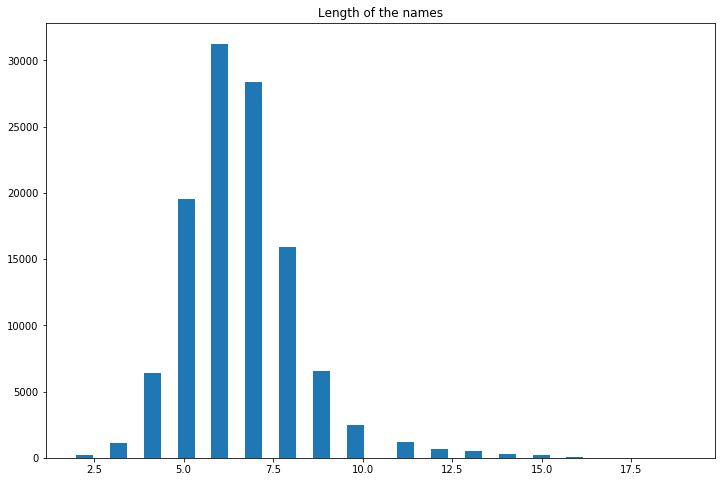

In [7]:
plt.figure(figsize=(12,8))
plt.hist([len(a) for a in names], bins=36)
plt.title("Length of the names")
plt.show()

In [8]:
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)
len_vocab

30

In [9]:
vocab

{' ',
 "'",
 '-',
 'END',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [10]:
print("Male : " + str(sum(gender=='M')))
print("Female : " + str(sum(gender=='F')))

Male : 44580
Female : 70147


In [11]:
char_index = dict((c, i) for i, c in enumerate(vocab))
char_index

{'w': 0,
 'END': 1,
 'z': 2,
 'b': 3,
 '-': 4,
 'g': 5,
 'p': 6,
 'd': 7,
 't': 8,
 'v': 9,
 "'": 10,
 'l': 11,
 'r': 12,
 'k': 13,
 'j': 14,
 'q': 15,
 'i': 16,
 'x': 17,
 'e': 18,
 'm': 19,
 'f': 20,
 'y': 21,
 'a': 22,
 's': 23,
 'u': 24,
 'o': 25,
 ' ': 26,
 'c': 27,
 'h': 28,
 'n': 29}

In [12]:
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

In [15]:
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list

# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

X = prepare_X(names.values)
y = prepare_y(gender)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [353]:
model = Sequential()
model.add(Bidirectional(LSTM(512, return_sequences=True), backward_layer=LSTM(512, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
#model.add(Bidirectional(LSTM(512, return_sequences=True, input_shape=(maxlen,len_vocab))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))
model.add(Dense(2, activity_regularizer=l2(0.002)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [354]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 20, 1024)          2224128   
_________________________________________________________________
dropout_52 (Dropout)         (None, 20, 1024)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 1024)              6295552   
_________________________________________________________________
dropout_53 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 2050      
_________________________________________________________________
activation_22 (Activation)   (None, 2)                 0         
Total params: 8,521,730
Trainable params: 8,521,730
Non-trainable params: 0
___________________________________________

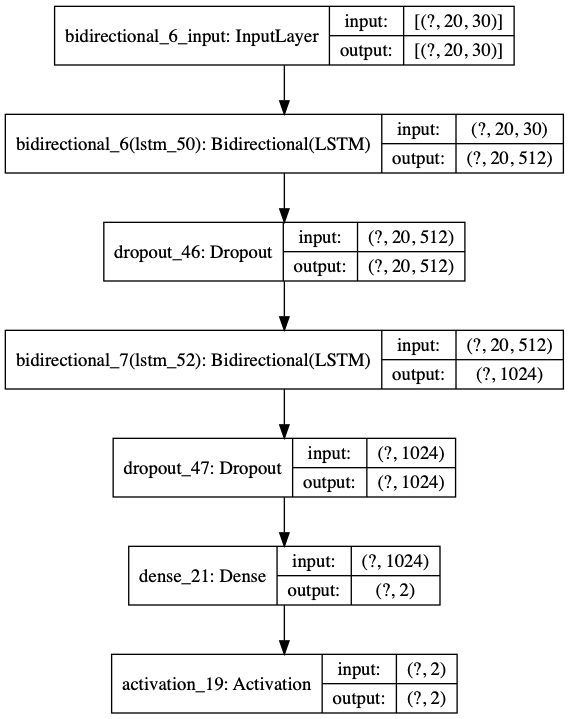

In [335]:
plot_model(model, to_file='model_2.png', show_shapes=True, expand_nested=True)

In [355]:
callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model_9.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [356]:
batch_size = 256
history = model.fit(X, y, batch_size=batch_size, epochs=35, verbose=1, validation_data =(X_2, y_2), callbacks=[callback, mc, reduce_lr_acc])

Train on 86045 samples, validate on 28682 samples
Epoch 1/35
86016/86045 [============================>.] - ETA: 0s - loss: 0.4662 - accuracy: 0.7795
Epoch 00001: saving model to best_model_9.h5
86045/86045 [==============================] - 1402s 16ms/sample - loss: 0.4662 - accuracy: 0.7795 - val_loss: 0.4304 - val_accuracy: 0.8070
Epoch 2/35
86016/86045 [============================>.] - ETA: 0s - loss: 0.3972 - accuracy: 0.8249
Epoch 00002: saving model to best_model_9.h5
86045/86045 [==============================] - 1386s 16ms/sample - loss: 0.3972 - accuracy: 0.8249 - val_loss: 0.3882 - val_accuracy: 0.8276
Epoch 3/35
67584/86045 [======================>.......] - ETA: 5:01 - loss: 0.3751 - accuracy: 0.8354WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy

Epoch 00003: saving model to best_model_9.h5
67584/86045 [======================>.......] - ETA: 5:01 - loss: 0.3751 - accuracy: 0.8354

KeyboardInterrupt: 

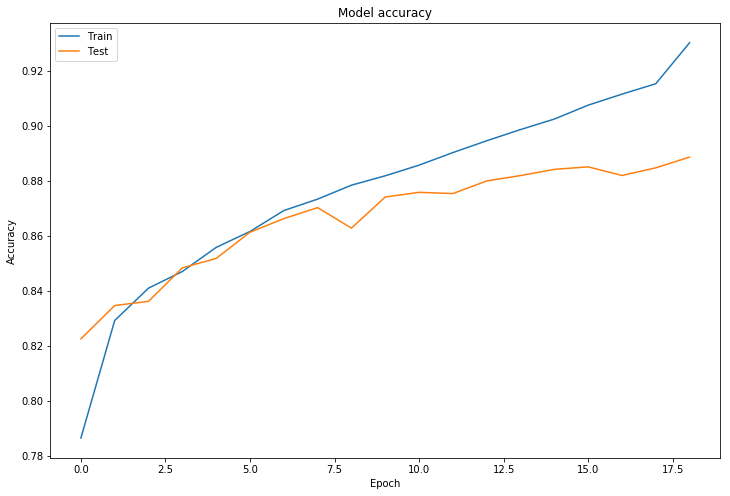

In [339]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

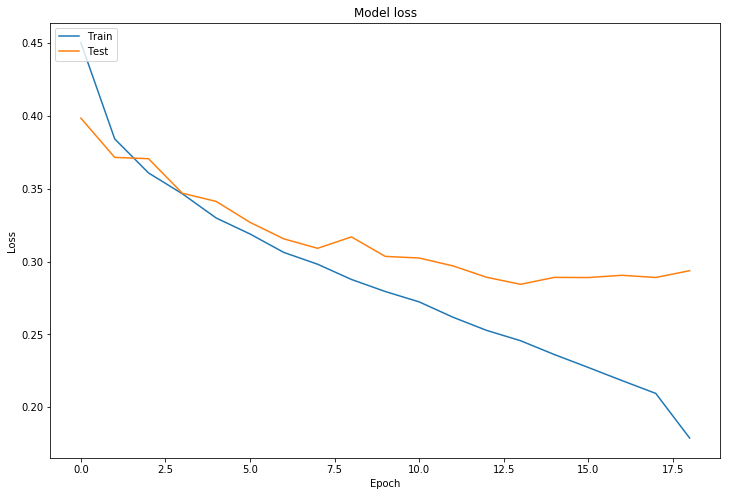

In [340]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
from tensorflow.keras.models import load_model

In [49]:
model = load_model(
    'best_model_5.h5',
    custom_objects=None,
    compile=True
)

In [50]:
new_names = ["maxime", "julie", "sami", 'ludivine', 'camille', 'nour', 'eva', 'naim', 'solène', 'caroline', 'maxime', 'vincent', 'bernard', "francois", "maël", "jean-jacques", "gregory", "anna", "olivier", "alexandre", "raphaël", "rachid", "samira"]

pred_name = [str(i)[0:maxlen] for i in new_names]
pred_name = [rmv_acc(i) for i in pred_name]

pred_names = []

for i in pred_name:
    tmp = [set_flag(char_index[j]) for j in str(i)]
    for k in range(0,maxlen - len(str(i))):
        tmp.append(set_flag(char_index["END"]))
    pred_names.append(tmp)
    

In [90]:
new_names = ["julie", "sami", 'ludivine', 'camille', 'nour', 'eva', 'naim', 'solène', 'caroline', 'maxime', 'vincent', 'bernard', "francois", "maël", "jean-jacques", "gregory", "anna", "olivier", "alexandre", "raphaël", "rachid", "samira"]
new_names = ["mael", "jenny", "marc"]
X_pred = prepare_X([rmv_acc(e) for e in new_names])


In [91]:
dict_answer = {0:"M", 1:"F"}

In [92]:
prediction = model.predict(X_pred)
prediction

array([[0.3685085 , 0.6314915 ],
       [0.14170532, 0.85829467],
       [0.8759549 , 0.12404503]], dtype=float32)

In [93]:
def pred(new_names, prediction, dict_answer):
    return_results = []
    k = 0
    for i in prediction:
        if max(i) < 0.65:
            return_results.append([new_names[k], "N"])
        else:
            return_results.append([new_names[k], dict_answer[np.argmax(i)]])
        k += 1
    return return_results

In [94]:
pred(new_names, prediction, dict_answer)

[['mael', 'N'], ['jenny', 'F'], ['marc', 'M']]